In [1]:
PATH = 'D:\\мфти\\диплом\\Новая папка\\data'
PATH_TO_PASTISR_blurred = 'blurred'


import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib

cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,20)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=21)

def get_rgb(x,  t_show=2):
    """Utility function to get a displayable rgb image 
    from a Sentinel-2 time series.
    """
    im = x[t_show, [2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

import sys

def get_radar(x, t_show=0):
    """Utility function to get a displayable image 
    from a Sentinel-1 time series.
    """
    im = x[batch_index, t_show].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im



import os
sats = ['S2']
id_patch = 10000
files = os.listdir(os.path.join(PATH, "test", "orig"))
data = np.load(
                    os.path.join(
                        PATH,
                        "test", "orig", 
                        files[5],
                    )
                ).astype(np.float32)
print(files[0])
print(np.amax(data))
print(np.mean(data))

S2_10033.npy
1.0
0.37186807


In [2]:
print(data.shape)

(43, 10, 128, 128)


In [3]:
x = [[1,2],[3,4],[5,6],[7,8]]
n = np.array(x)
print(n[1,[1,0]])

[4 3]


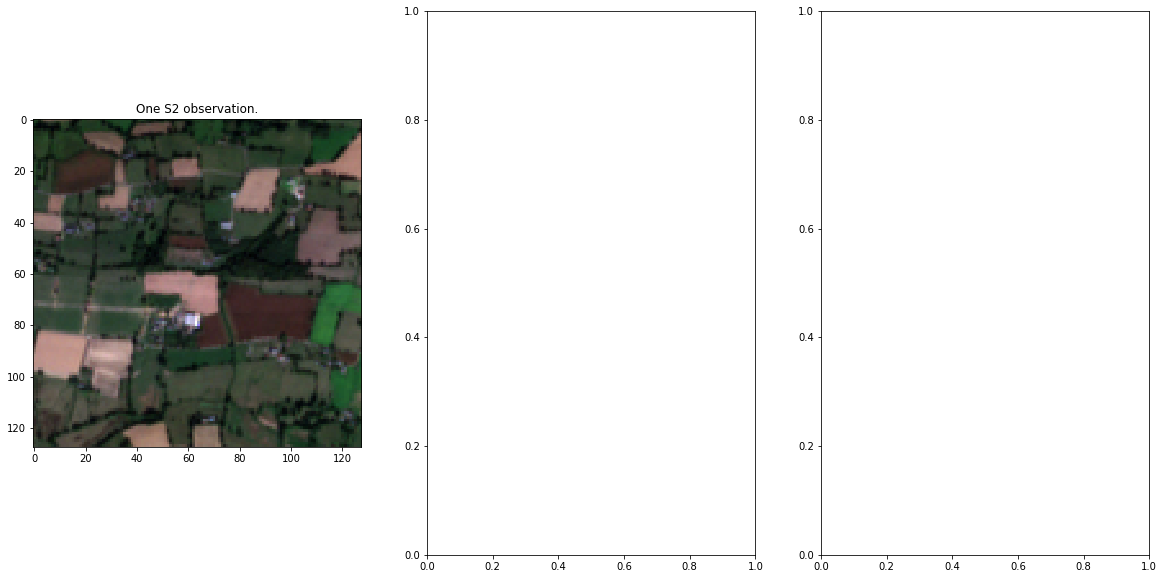

In [4]:
#!g1.1
bid = 0 

fix, axes = plt.subplots(1, 3, figsize=(20,10))
x = torch.from_numpy(data)

axes[0].imshow(get_rgb(x))
#axes[1].imshow(get_rgb(x, t_show=15))
#axes[2].imshow(get_rgb(x, t_show=30))

#axes[1,0].imshow(target_heatmap[bid].squeeze())
#axes[1,1].imshow(instance_ids[bid].squeeze(), cmap='prism', alpha=.6)
#axes[1,2].imshow(pixel_semantic_annotation[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)
#
axes[0].set_title('One S2 observation.')
#axes[0,1].set_title('One S1A observation.')
#axes[0,2].set_title('One S1D observation.')

"""axes[1,0].set_title('Centerness Ground Truth.')
axes[1,1].set_title('Instance masks.')
axes[1,2].set_title('Semantic labels.')"""

plt.show()

In [6]:
from PIL import Image
y = get_rgb(x)
print(y.shape)
im = Image.fromarray((y * 255).astype(np.uint8))
im.save("orig2.jpeg")

(128, 128, 3)


In [8]:
!pip install scikit-image

In [7]:
import skimage
def fixe(x):
    return math.trunc(x)

def find(x):
    y = list()
    for i in range(x.shape[0]):
        if x[i]:
            y.append(i)
    return np.array(y)

def meshgrid(x, y):
    x1 = [i for i in x]
    x2 = []
    for i in range(len(y)):
        x2.append(x1)
    y2 = list()
    for i in y:
        y1 = list()
        for j in range(len(x)):
            y1.append(i)
        y2.append(y1)
    y2 = np.array(y2)
    x2 = np.array(x2)
    return [x2, y2]

def flip(A, dim = 0):
    return np.flip(A, axis = dim)

def rot90(A, k):
    if k == 2:
        return flip(flip(A, 0), 1)
    else:
        raise Exception("k!=2")
        
def sign(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0

def motion(len1, phi):
    len1 = max(1, len1)
    half = (len1-1)/2
    phi = (phi % 180) / 180 * math.pi
    
    cosphi = math.cos(phi)
    sinphi = math.sin(phi)
    xsign = sign(cosphi)
    linewdt = 1
    eps = pow(2, -52)
    
    sx = fixe(half*cosphi + linewdt*xsign - len1*eps)
    if xsign > 0:
        sx += 1
    else:
        sx -= 1
    sy = fixe(half*sinphi + linewdt - len1*eps)
    [x, y] = meshgrid([i for i in range(0, sx, xsign)], [i for i in range(sy)])
    dist2line = (y*cosphi-x*sinphi)
    
    rad = np.sqrt(np.square(x) + np.square(y))
    lastpix = np.where((rad >= half) & (abs(dist2line) <= linewdt))
    x2lastpix = half - np.absolute((x[lastpix] + dist2line[lastpix]*sinphi)/cosphi)
    dist2line[lastpix] = np.sqrt(np.square(dist2line[lastpix]) + np.square(x2lastpix))
    dist2line = linewdt + eps - np.absolute(dist2line)
    dist2line[dist2line<0] = 0
    h = rot90(dist2line,2)
    newh = np.zeros((2 * h.shape[0], 2 * h.shape[1]))
    newh[:h.shape[0], :h.shape[1]] = h
    newh[h.shape[0]:newh.shape[0], h.shape[1]:newh.shape[1]] = dist2line
    h = newh
    h = h / (np.sum(h) + eps / len1 / len1)
    return h
    
    
def gasuss_noise(image, mean=0, var=0.001):

    return skimage.util.random_noise(image, mode = 'gaussian', var = var)


In [8]:
import numpy as np
import os
import cv2
def noisy(noise_typ,image, var = 0.1):
    if noise_typ == "gauss":
        row,col= image.shape
        ch = 1
        mean = 0
        #var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        return noisy
    else:
        row,col = image.shape
        ch = 1
        s_vs_p = 0.5
        amount = var
        if var == 0.1:
            amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

      # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
from numpy import fft

def extension_PSF(image0,PSF0):
    [img_h,img_w] = image0.shape
    [h,w] = PSF0.shape
    PSF=np.zeros((img_h,img_w))
    PSF[0:h, 0:w] = PSF0             
    return PSF

def make_blurred_and_noisy(input, PSF, eps):
    input_fft = fft.fft2 (input) # преобразование Фурье двумерного массива
    PSF_fft = fft.fft2(PSF) + eps
    blurred = fft.ifft2(input_fft * PSF_fft)
    blurred = np.abs(blurred)
    blurred = noisy('gauss', blurred, 0.0001)
    return blurred

In [25]:
        import random
        s = 'test'
        files2 = os.listdir(os.path.join(PATH, s, "orig"))
        i = 0
        data = np.load(
                    os.path.join(
                        PATH, s, "orig", 
                        files2[i],
                    )
                ).astype(np.float32)
        y = np.empty(data.shape)
        l = list()
        p = list()
        for j in range(data.shape[0]):
            img = data[j]
  
            #Определяем величину сдвига и угол 
            len1 = random.choices(a_list, distribution)[0]
            phi = random.uniform(0, 180)
        
            #Создаём ядро
            kernel = motion(len1, phi)
            
            #Нормализуем донные о величине сдвига и угла
            len1 -= 6
            len1 /= 4
            phi /= 180
            
            #Сохраняем данные о величине сдвига и угле
            l.append(len1)
            p.append(phi)
        
            # Применяем ядро.
            for k in range(img.shape[0]):
                blurredimg = make_blurred_and_noisy(img[k], extension_PSF(img[k], kernel), 0.01)
                y[j][k] = np.array(blurredimg)
            #добавляем шум
            #y[j] = y[j] + y[j] * np.random.normal(0, 0.01, y[j].shape)
    
            #print(1)

In [9]:
a_list = [6, 7, 8, 9, 10]
distribution = [0.15, 0.2, 0.3, 0.2, 0.15]
import cv2
import math

In [10]:
i = 5
data = np.load(
                    os.path.join(
                        PATH, s, "orig", 
                        files2[i],
                    )
                ).astype(np.float32)
data1 = np.load(
                    os.path.join(
                        PATH, s, "blurred", 
                        files2[i],
                    )
                ).astype(np.float32)


NameError: name 's' is not defined

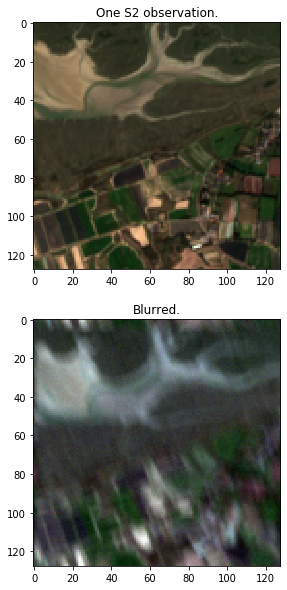

In [26]:
bid = 0 

fix, axes = plt.subplots(2, 1, figsize=(20,10))
x = torch.from_numpy(data)
x1 = torch.from_numpy(y)

axes[0].imshow(get_rgb(x, batch_index=bid))
axes[1].imshow(get_rgb(x1, batch_index=bid))
#axes[0,2].imshow(get_radar(x, batch_index=bid, orbit='D'))

#axes[1,0].imshow(target_heatmap[bid].squeeze())
#axes[1,1].imshow(instance_ids[bid].squeeze(), cmap='prism', alpha=.6)
#axes[1,2].imshow(pixel_semantic_annotation[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)
#
axes[0].set_title('One S2 observation.')
axes[1].set_title('Blurred.')
#axes[0,2].set_title('One S1D observation.')

"""axes[1,0].set_title('Centerness Ground Truth.')
axes[1,1].set_title('Instance masks.')
axes[1,2].set_title('Semantic labels.')"""

plt.show()

In [27]:
import random
import math
import cv2
from IPython.display import clear_output
a_list = [6, 7, 8, 9, 10]
distribution = [0.15, 0.2, 0.3, 0.2, 0.15]
for s in ('train', 'test', 'valid'):
    files2 = os.listdir(os.path.join(PATH, s, "orig"))
    for i in range(len(files2)):
        clear_output(wait = True)
        print(s + ': ' + str(i) + "/" + str(len(files2)))
    #print(1)
        data = np.load(
                    os.path.join(
                        PATH, s, "orig", 
                        files2[i],
                    )
                ).astype(np.float32)
        y = np.empty(data.shape)
        l = list()
        p = list()
        for j in range(data.shape[0]):
            img = data[j]
  
            #Определяем величину сдвига и угол 
            len1 = random.choices(a_list, distribution)[0]
            phi = random.uniform(0, 180)
        
            #Создаём ядро
            kernel = motion(len1, phi)
            
            #Нормализуем донные о величине сдвига и угла
            len1 -= 6
            len1 /= 4
            phi /= 180
            
            #Сохраняем данные о величине сдвига и угле
            l.append(len1)
            p.append(phi)
        
            # Применяем ядро.
            for k in range(img.shape[0]):
                blurredimg = make_blurred_and_noisy(img[k], extension_PSF(img[k], kernel), 0.01)
                y[j][k] = np.array(blurredimg)
            #добавляем шум
            #y[j] = y[j] + y[j] * np.random.normal(0, 0.01, y[j].shape)
    
            #print(1)
        li = [l, p]
        li = np.array(li)
        np.save(os.path.join(PATH, s, "blurred",
                        files2[i]), y)
        np.save(os.path.join(PATH, s,  "param", 
                        files2[i]), li)
    


valid: 314/315


In [24]:
import random
import math
import cv2
from IPython.display import clear_output
a_list = [6, 7, 8, 9, 10]
distribution = [0.15, 0.2, 0.3, 0.2, 0.15]
for s in ('test', 'valid'):
    files2 = os.listdir(os.path.join(PATH, s, "orig"))
    for i in range(len(files2)):
        clear_output(wait = True)
        print(s + ': ' + str(i) + "/" + str(len(files2)))
    #print(1)
        data = np.load(
                    os.path.join(
                        PATH, s, "orig", 
                        files2[i],
                    )
                ).astype(np.float32)
        y = list(range(data.shape[0]))
        l = list()
        p = list()
        for j in range(data.shape[0]):
            img = data[j]
  
            #Определяем величину сдвига и угол 
            len1 = random.choices(a_list, distribution)[0]
            phi = random.uniform(0, 180)
        
            #Создаём ядро
            kernel = motion(len1, phi)
            
            #Нормализуем донные о величине сдвига и угла
            len1 -= 6
            len1 /= 4
            phi /= 180
            
            #Сохраняем данные о величине сдвига и угле
            l.append(len1)
            p.append(phi)
        
            # Применяем ядро.
            blurredimg = make_blurred_and_noisy(img, kernel)
            y[j] = np.array(blurredimg)
            #добавляем шум
            y[j] = y[j] + y[j] * np.random.normal(0, 0.01, y[j].shape)
    
            #print(1)
        li = [l, p]
        li = np.array(li)
        np.save(os.path.join(PATH, s, "blurred",
                        files2[i]), y)
        np.save(os.path.join(PATH, s,  "param", 
                        files2[i]), li)
    


valid: 314/315


In [11]:
sats = ['S2']
id_patch = 10000
data = np.load(
                    os.path.join(
                        PATH, "test", "blurred", os.listdir(os.path.join(PATH, "test", "blurred"))[5]
                    )
                ).astype(np.float32)

In [13]:
bid = 0 

#fix, axes = plt.subplots(1, 1, figsize=(20,10))
x = torch.from_numpy(data)
print(np.min(data))
x = get_rgb(x)
print(np.isfinite(x).any())

-0.041510273
True


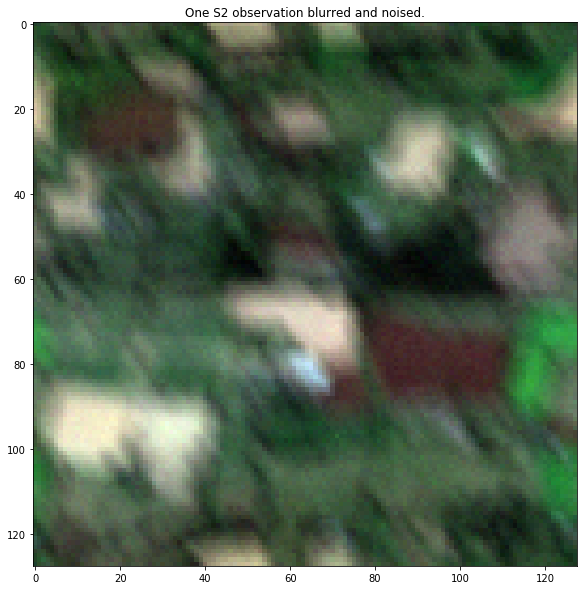

In [15]:
#!g1.1
bid = 0 

fix, axes = plt.subplots(1, 1, figsize=(20,10))
x = torch.from_numpy(data)

axes.imshow(get_rgb(x))
#cv2.imwrite('blur.png', get_rgb(x, batch_index=bid))
#axes[0,1].imshow(get_radar(x, batch_index=bid, orbit='A'))
#axes[0,2].imshow(get_radar(x, batch_index=bid, orbit='D'))

#axes[1,0].imshow(target_heatmap[bid].squeeze())
#axes[1,1].imshow(instance_ids[bid].squeeze(), cmap='prism', alpha=.6)
#axes[1,2].imshow(pixel_semantic_annotation[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)
#
axes.set_title('One S2 observation blurred and noised.')
#axes[0,1].set_title('One S1A observation.')
#axes[0,2].set_title('One S1D observation.')

"""axes[1,0].set_title('Centerness Ground Truth.')
axes[1,1].set_title('Instance masks.')
axes[1,2].set_title('Semantic labels.')"""

plt.show()

In [31]:
#!g1.1
from PIL import Image
y = get_rgb(x, batch_index=bid)
print(x.shape)
im = Image.fromarray((y * 255).astype(np.uint8))
im.save("blur.jpeg")

torch.Size([43, 10, 128, 128])


In [ ]:
li = np.load(
                    os.path.join(
                        PATH_TO_PASTISR_blurred,
                        "DATA_S2",
                        "param/S2_10000.npy",
                    )
                ).astype(np.float32)
            

In [ ]:
print(li.shape)

In [ ]:
print(li[0][0], li[1][0])

In [35]:
data = np.load(
                    os.path.join(
                        PATH, "test", "blurred", os.listdir(os.path.join(PATH, "test", "blurred"))[7]
                    )
                ).astype(np.float32)

In [36]:
data1 = np.load(
                    os.path.join(
                        PATH, "test", "orig", os.listdir(os.path.join(PATH, "test", "orig"))[7]
                    )
                ).astype(np.float32)

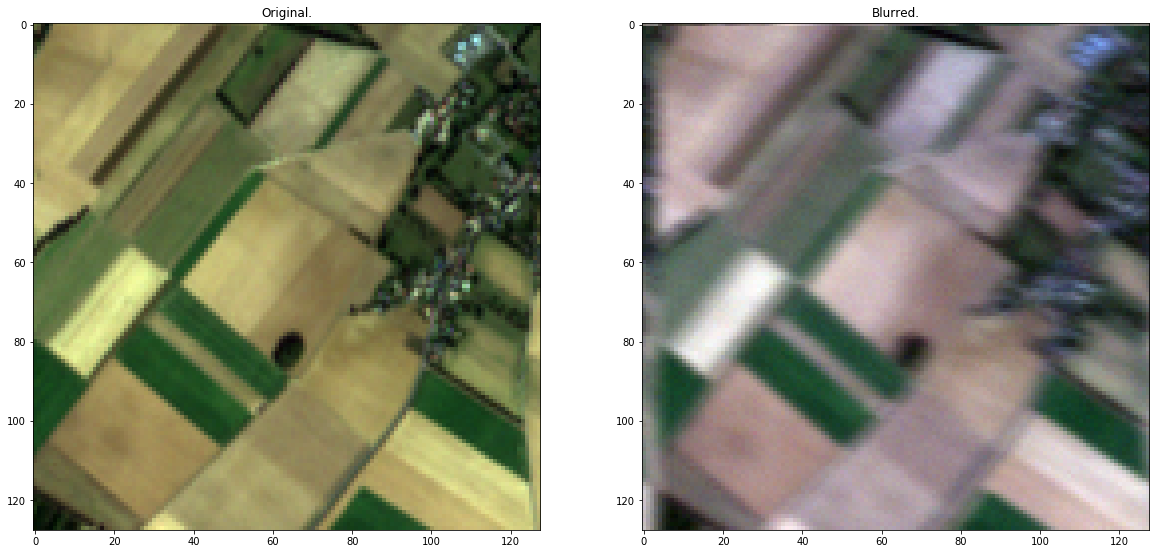

In [37]:
#!g1.1
bid = 0 

fix, axes = plt.subplots(1, 2, figsize=(20,10))
x = torch.from_numpy(data)
x1 = torch.from_numpy(data1)

axes[0].imshow(get_rgb(x1))
#cv2.imwrite('blur.png', get_rgb(x, batch_index=bid))
axes[1].imshow(get_rgb(x))
#axes[0,2].imshow(get_radar(x, batch_index=bid, orbit='D'))

#axes[1,0].imshow(target_heatmap[bid].squeeze())
#axes[1,1].imshow(instance_ids[bid].squeeze(), cmap='prism', alpha=.6)
#axes[1,2].imshow(pixel_semantic_annotation[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)
#
axes[0].set_title('Original.')
axes[1].set_title('Blurred.')
#axes[0,2].set_title('One S1D observation.')

"""axes[1,0].set_title('Centerness Ground Truth.')
axes[1,1].set_title('Instance masks.')
axes[1,2].set_title('Semantic labels.')"""

plt.show()

In [38]:
from PIL import Image
y = get_rgb(x1)
print(x.shape)
im = Image.fromarray((y * 255).astype(np.uint8))
im.save("orig3.jpeg")

torch.Size([43, 10, 128, 128])


In [39]:
from PIL import Image
y = get_rgb(x)
print(x.shape)
im = Image.fromarray((y * 255).astype(np.uint8))
im.save("blur3.jpeg")

torch.Size([43, 10, 128, 128])


In [43]:
label = np.load(
                    os.path.join(
                        PATH, "test", "param", os.listdir(os.path.join(PATH, "test", "param"))[7]
                    )
                ).astype(np.float32)

In [44]:
print(label.shape)

(2, 43)


In [45]:
print(label[:, 0])

[0.25       0.93441945]
